In [49]:
!export TF_BLAS=libopenblas
!export LD_LIBRARY_PATH=/usr/lib/x86_64-linux-gnu:$LD_LIBRARY_PATH
!export OPENBLAS_NUM_THREADS=8  # You can adjust this based on your CPU cores

In [50]:
import pandas as pd
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import glob

# Data

In [51]:
# construct dataframe from multiple csv files

# get list of available csv files
csv_files = glob.glob('./data/*.csv')

# read each file and create final df
dataframes = []
for file in csv_files:
    temp_df = pd.read_csv(file)
    dataframes.append(temp_df)

df = pd.concat(dataframes, ignore_index=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')  # convert unix_train time to date time
df.sort_values(by='Timestamp', inplace=True)  # sort by timestamp

In [52]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88801 entries, 82354 to 43821
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Number     88801 non-null  float64       
 1   Timestamp  88801 non-null  datetime64[ns]
 2   IP         88801 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.7+ MB


Number       0
Timestamp    0
IP           0
dtype: int64

# Feature Eng.

In [53]:
n_features = 3  # number of features used to train
n_lookback = 20  # Number of historical data points to learn for each result

In [54]:
def get_time_attr(row: pd.Series, part: str):
    """Return the specified part of the timestamp.

    Args:
        row (pd.Series): Dataframe row
        part (str): Should be a valid `pandas.Timestamp` attribute

    Returns:
        any: Specified attribute of the timestamp
    """
    return getattr(row, part)

In [55]:
# Get time attributes and add to dataframe
needed_time_attrs = ["hour", "minute"]

for attr in needed_time_attrs:
    df[attr] = df["Timestamp"].apply(lambda x: get_time_attr(x, attr))


## One Hot Encode Numbers

In [56]:
# Convert Number column to integer
df['Number'] = df['Number'].astype(int)

# One hot encoded columns
encoded_numbers = pd.get_dummies(df['Number'], prefix='Number')

# Update number of used features
n_features = n_features + encoded_numbers.shape[1]

In [57]:
# Remove Number column from df
df.drop('Number', axis=1, inplace=True)

# Concatenate the one hot encoded columns to the main dataframe
df = pd.concat([df, encoded_numbers], axis=1)

# Data preprocessing

In [58]:
# Remove unwanted columns
df.drop('IP', axis=1, inplace=True)

df.drop('Timestamp', axis=1, inplace=True)
n_features -= 1  # Remove timestamp column

In [59]:
# train test split
train_fraction = 0.8
split_point = int(len(df) * train_fraction)

df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

In [60]:
# raw sequence data
train_raw_seq = np.array(df_train)

In [ ]:
X_train = train_raw_seq[:]

In [37]:
# look back sequences
def split_sequence(sequence: np.ndarray, num_steps: int, num_features: int):
    """Make sub sequences of n length and the prediction value and return them

    Args:
        sequence (numpy.ndarray): The sequence of training data
        num_steps (int): How many past data points to look at
        num_features (int): Total number of features in given dataset
    """

    x, y = [], []

    for i in range(len(sequence)):
        # find index of end of current learning slice
        end_i = i + num_steps

        # check if end is beyond the length of sequence
        if end_i > len(sequence) - 1:  # -1 since last element needs to be the prediction value
            break
        else:
            seq_x = sequence[i:end_i]  # training sequence
            seq_y = sequence[end_i][2:]  # prediction value

            x.append(seq_x)
            y.append(seq_y)

    # Reshape data
    x = np.array(x)
    y = np.array(y)

    x = x.reshape(x.shape[0], x.shape[1], num_features)  # each internal array contains data of each timestep
    y = y.reshape(-1, num_features - 2)  # each internal array contains data of each timestep
    
    return x, y

In [38]:
# Get train, test splits
X_train, y_train = split_sequence(train_raw_seq, n_lookback, n_features)

# Models

In [39]:
# Import model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense

In [40]:
y_train.shape

(71020, 100)

In [94]:
# Construct model
def train_cnn_model(X_train: np.array, y_train: np.array, num_lookback: int, num_features: int, activation: str ='relu', num_epochs: int = 15, optimizer: str ='adam', loss: str ='categorical_crossentropy'):
    # define model
    model = Sequential()

    # Primary layer -  CNN
    model = Sequential()
    model.add(Conv1D(32, 1, activation=activation, input_shape=(num_lookback, num_features)))
    model.add(Dropout(0.2))
    # model.add(Conv1D(16, 1, activation=activation, input_shape=(num_lookback, num_features)))
    # model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(200, activation=activation))
    model.add(Dropout(0.5))
    # model.add(Dense(100, activation=activation))
    # model.add(Dropout(0.5))

    model.add(Dense(100, activation='softmax'))  # 100 output classes

    # model.compile(optimizer=optimizer, loss=loss)
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    # fit model
    history = model.fit(X_train, y_train, epochs=num_epochs, verbose=1, validation_split=0.2)

    # plot train and validation loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"], loc="upper right")
    plt.show()

    # return trained model object
    return model

Epoch 1/15
1776/1776 [==============================] - 5s 2ms/step - loss: 4.6280 - val_loss: 4.6054
Epoch 2/15
1776/1776 [==============================] - 4s 3ms/step - loss: 4.6054 - val_loss: 4.6059
Epoch 3/15
1776/1776 [==============================] - 4s 2ms/step - loss: 4.6052 - val_loss: 4.6061
Epoch 4/15
1776/1776 [==============================] - 4s 2ms/step - loss: 4.6051 - val_loss: 4.6061
Epoch 5/15
1776/1776 [==============================] - 4s 2ms/step - loss: 4.6052 - val_loss: 4.6061
Epoch 6/15
1776/1776 [==============================] - 4s 2ms/step - loss: 4.6051 - val_loss: 4.6062
Epoch 7/15
1776/1776 [==============================] - 4s 2ms/step - loss: 4.6051 - val_loss: 4.6061
Epoch 8/15
1776/1776 [==============================] - 4s 2ms/step - loss: 4.6056 - val_loss: 4.6063
Epoch 9/15
1776/1776 [==============================] - 4s 2ms/step - loss: 4.6053 - val_loss: 4.6068
Epoch 10/15
1776/1776 [==============================] - 4s 2ms/step - loss: 4.605

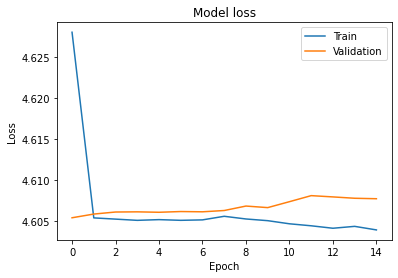

In [95]:
model = train_cnn_model(X_train, y_train, n_lookback, n_features, num_epochs=15)

# Evaluate

In [43]:
# define evaluate function
def evaluate_msle(model: tensorflow.keras.models.Sequential, preds: np.array, ground_truths: np.array):
    m = tensorflow.keras.metrics.MeanSquaredLogarithmicError()
    m.update_state(ground_truths, preds)
    metric = m.result().numpy()
    m.reset_state()
    return metric

In [87]:
def get_max_indices(preds: np.array):
    """Return the index of the maximum value in each array of the given array

    Args:
        preds (np.array): Array of arrays

    Returns:
        list: List of indices
    """
    indices = []
    for p in preds:
        indices.append(p.tolist().index(max(p)))
    return indices

In [44]:
# Load models again
# model = tensorflow.keras.models.load_model(model_2_path, compile=False)

In [65]:
# test data
test_raw_seq = np.array(df_test)
X_test, y_test = split_sequence(test_raw_seq, n_lookback, n_features)

In [66]:
# make predictions
preds = model.predict(X_test)

  1/555 [..............................] - ETA: 28s

555/555 [==============================] - 1s 1ms/step


In [67]:
# print("Model 1 MSLE: ", evaluate_msle(model_1, preds_1, y_test))
print("Model 2 MSLE: ", evaluate_msle(model, preds, y_test))

Model 2 MSLE:  0.0047657806


In [93]:
np.array(get_max_indices(preds)).nunique()

AttributeError: 'numpy.ndarray' object has no attribute 'nunique'